# Network Intrusion Detection System - NIDS

# 1. Prerequisites

## 1.1. Import Libraries

In [30]:
import os
import gc
import time
import optuna
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.neighbors import KNeighborsClassifier
from tensorflow import keras
from prettytable import PrettyTable
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, root_mean_squared_error, mean_squared_error, mean_absolute_error, precision_score, confusion_matrix, multilabel_confusion_matrix, classification_report, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm
from sklearn.svm import LinearSVC
from tensorflow.keras.utils import to_categorical

import warnings
warnings.filterwarnings('ignore')

In [2]:
for dirname, _, filenames in os.walk('data/CIC_IDS_2017/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

data/CIC_IDS_2017/prepared_train_labels.npy
data/CIC_IDS_2017/MachineLearningCSV.md5
data/CIC_IDS_2017/download_dataset.sh
data/CIC_IDS_2017/README.md
data/CIC_IDS_2017/prepared_train_data.npy
data/CIC_IDS_2017/GeneratedLabelledFlows.zip
data/CIC_IDS_2017/MachineLearningCSV.zip
data/CIC_IDS_2017/GeneratedLabelledFlows.md5
data/CIC_IDS_2017/MachineLearningCVE/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
data/CIC_IDS_2017/MachineLearningCVE/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
data/CIC_IDS_2017/MachineLearningCVE/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
data/CIC_IDS_2017/MachineLearningCVE/Friday-WorkingHours-Morning.pcap_ISCX.csv
data/CIC_IDS_2017/MachineLearningCVE/Monday-WorkingHours.pcap_ISCX.csv
data/CIC_IDS_2017/MachineLearningCVE/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
data/CIC_IDS_2017/MachineLearningCVE/Wednesday-workingHours.pcap_ISCX.csv
data/CIC_IDS_2017/MachineLearningCVE/Tuesday-WorkingHours.pcap_ISCX.csv
data/CIC_IDS_20

# 2. Data Analysis

In [3]:
monday = pd.read_csv('data/CIC_IDS_2017/MachineLearningCVE/Monday-WorkingHours.pcap_ISCX.csv', sep=",", encoding='utf-8')
tuesday = pd.read_csv('data/CIC_IDS_2017/MachineLearningCVE/Tuesday-WorkingHours.pcap_ISCX.csv', sep=",", encoding='utf-8')
wednesday = pd.read_csv('data/CIC_IDS_2017/MachineLearningCVE/Wednesday-workingHours.pcap_ISCX.csv', sep=",", encoding='utf-8')
thursday_morning = pd.read_csv('data/CIC_IDS_2017/MachineLearningCVE/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv', sep=",", encoding='utf-8')
thursday_afternoon = pd.read_csv('data/CIC_IDS_2017/MachineLearningCVE/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv', sep=",", encoding='utf-8')
friday_ddos = pd.read_csv('data/CIC_IDS_2017/MachineLearningCVE/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv', sep=",", encoding='utf-8')
friday_pcap = pd.read_csv('data/CIC_IDS_2017/MachineLearningCVE/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv', sep=",", encoding='utf-8')
friday_morning = pd.read_csv('data/CIC_IDS_2017/MachineLearningCVE/Friday-WorkingHours-Morning.pcap_ISCX.csv', sep=",", encoding='utf-8')
monday.name = 'Monday'
tuesday.name = 'Tuesday'
wednesday.name = 'Wednesday'
thursday_morning.name = 'Thursday_Morning'
thursday_afternoon.name = 'Thursday_Afternoon'
friday_ddos.name = 'Friday_DDoS'
friday_pcap.name = 'Friday_Pcap'
friday_morning.name = 'Friday_Morning'

In [4]:
dataframes = [monday, tuesday, wednesday, thursday_morning, thursday_afternoon, friday_ddos, friday_morning, friday_pcap]
data = pd.concat(dataframes)

In [5]:
data.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,49188,4,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,49188,1,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,49188,1,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,49188,1,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,49486,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [6]:
data[' Flow Duration'].head(20)

0         4
1         1
2         1
3         1
4         3
5         1
6         1
7         1
8       609
9       879
10     1160
11      524
12        6
13     1119
14    18378
15      822
16      876
17     1009
18      616
19        5
Name:  Flow Duration, dtype: int64

In [7]:
data[' Label']

0         BENIGN
1         BENIGN
2         BENIGN
3         BENIGN
4         BENIGN
           ...  
286462    BENIGN
286463    BENIGN
286464    BENIGN
286465    BENIGN
286466    BENIGN
Name:  Label, Length: 2830743, dtype: object

In [8]:
data.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,49188,4,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,49188,1,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,49188,1,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,49188,1,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,49486,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2830743 entries, 0 to 286466
Data columns (total 79 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0    Destination Port             int64  
 1    Flow Duration                int64  
 2    Total Fwd Packets            int64  
 3    Total Backward Packets       int64  
 4   Total Length of Fwd Packets   int64  
 5    Total Length of Bwd Packets  int64  
 6    Fwd Packet Length Max        int64  
 7    Fwd Packet Length Min        int64  
 8    Fwd Packet Length Mean       float64
 9    Fwd Packet Length Std        float64
 10  Bwd Packet Length Max         int64  
 11   Bwd Packet Length Min        int64  
 12   Bwd Packet Length Mean       float64
 13   Bwd Packet Length Std        float64
 14  Flow Bytes/s                  float64
 15   Flow Packets/s               float64
 16   Flow IAT Mean                float64
 17   Flow IAT Std                 float64
 18   Flow IAT Max               

In [10]:
data.columns

Index([' Destination Port', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s',
       ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min',
       'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max',
       ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std',
       ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags',
       ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length',
       ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s',
       ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean',
       ' Packet Length Std', ' Packet Length Variance', '

In [11]:
data[' Label'].unique()

array(['BENIGN', 'FTP-Patator', 'SSH-Patator', 'DoS slowloris',
       'DoS Slowhttptest', 'DoS Hulk', 'DoS GoldenEye', 'Heartbleed',
       'Web Attack � Brute Force', 'Web Attack � XSS',
       'Web Attack � Sql Injection', 'Infiltration', 'DDoS', 'Bot',
       'PortScan'], dtype=object)

In [12]:
data[' Class'] = ["BENIGN" if x=='BENIGN' else "MALICIOUS" for x in data[' Label']]

In [13]:
labels = data[' Label'].unique()
values = data[' Label'].value_counts()

In [14]:
def unique_attacks(df, table_name, labels, values):
    """
    Print unique attack labels and count in the dataset
    """
    table = PrettyTable(["Label", "Count"])
    for label, value in zip(labels, values):
        table.add_row([label, value])
    info = table.get_string()
    with open(f"tables/{table_name}.txt", 'w') as f:
        f.write(info)
    print(table)
    print(f"Table saved as {table_name}.txt")

In [15]:
unique_attacks(data, "Unique_attacks", labels, values)

+----------------------------+---------+
|           Label            |  Count  |
+----------------------------+---------+
|           BENIGN           | 2273097 |
|        FTP-Patator         |  231073 |
|        SSH-Patator         |  158930 |
|       DoS slowloris        |  128027 |
|      DoS Slowhttptest      |  10293  |
|          DoS Hulk          |   7938  |
|       DoS GoldenEye        |   5897  |
|         Heartbleed         |   5796  |
|  Web Attack � Brute Force  |   5499  |
|      Web Attack � XSS      |   1966  |
| Web Attack � Sql Injection |   1507  |
|        Infiltration        |   652   |
|            DDoS            |    36   |
|            Bot             |    21   |
|          PortScan          |    11   |
+----------------------------+---------+
Table saved as Unique_attacks.txt


In [16]:
def missing_values(df, table_name):
    """
    Print a table with missing values
    """
    table = PrettyTable(["Column", "All Values", "Missing Values", "% of missing values"])
    NaN_columns = []
    columns = df.columns
    for column in columns:
        all_values = df[column].count()
        missing_values = df[column].isna().sum()
        if missing_values > 0:
            NaN_columns.append(column)
        percentage = f'{(missing_values / all_values)*100:.2f}'
        table.add_row([column, all_values, missing_values, f'{percentage}%'])
    data = table.get_string()
    with open(f"tables/{table_name}.txt", 'w') as f:
        f.write(data)
    print(table)
    if len(NaN_columns) > 0:
        print(f"Columns with missing values: {NaN_columns}")
    print(f"Table saved as {table_name}.txt")

In [17]:
data = data.replace([-np.inf, np.inf], np.nan)
missing_values(data, "Missing_data")

+------------------------------+------------+----------------+---------------------+
|            Column            | All Values | Missing Values | % of missing values |
+------------------------------+------------+----------------+---------------------+
|       Destination Port       |  2830743   |       0        |        0.00%        |
|         Flow Duration        |  2830743   |       0        |        0.00%        |
|       Total Fwd Packets      |  2830743   |       0        |        0.00%        |
|    Total Backward Packets    |  2830743   |       0        |        0.00%        |
| Total Length of Fwd Packets  |  2830743   |       0        |        0.00%        |
|  Total Length of Bwd Packets |  2830743   |       0        |        0.00%        |
|     Fwd Packet Length Max    |  2830743   |       0        |        0.00%        |
|     Fwd Packet Length Min    |  2830743   |       0        |        0.00%        |
|    Fwd Packet Length Mean    |  2830743   |       0        |   

In [18]:
data.dropna(inplace=True)
missing_values(data, "Updated_data")

+------------------------------+------------+----------------+---------------------+
|            Column            | All Values | Missing Values | % of missing values |
+------------------------------+------------+----------------+---------------------+
|       Destination Port       |  2827876   |       0        |        0.00%        |
|         Flow Duration        |  2827876   |       0        |        0.00%        |
|       Total Fwd Packets      |  2827876   |       0        |        0.00%        |
|    Total Backward Packets    |  2827876   |       0        |        0.00%        |
| Total Length of Fwd Packets  |  2827876   |       0        |        0.00%        |
|  Total Length of Bwd Packets |  2827876   |       0        |        0.00%        |
|     Fwd Packet Length Max    |  2827876   |       0        |        0.00%        |
|     Fwd Packet Length Min    |  2827876   |       0        |        0.00%        |
|    Fwd Packet Length Mean    |  2827876   |       0        |   

# Plots

In [32]:
def pair_plot(df, hue, plot_name):
    selected_features=[' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets', hue]
    pairplot = sns.pairplot(df[selected_features], hue=hue)
    plt.show()
    fig = pairplot.fig
    fig.savefig(f"images/plots/{plot_name}.png")

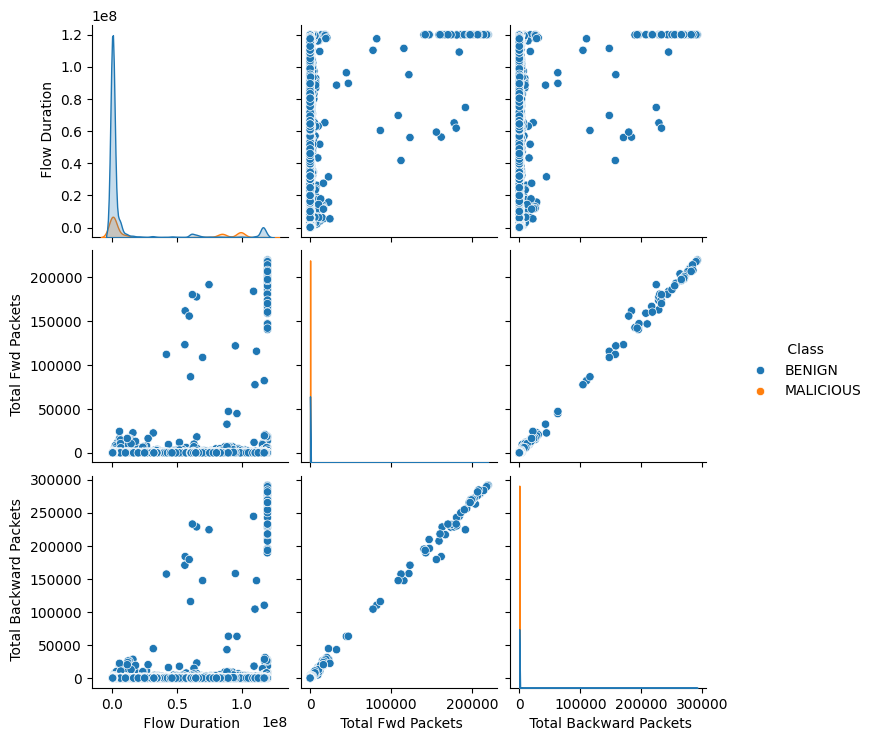

CPU times: user 16min 28s, sys: 2.94 s, total: 16min 31s
Wall time: 16min 27s


In [33]:
%%time
pair_plot(data, ' Class', "Pairplot")

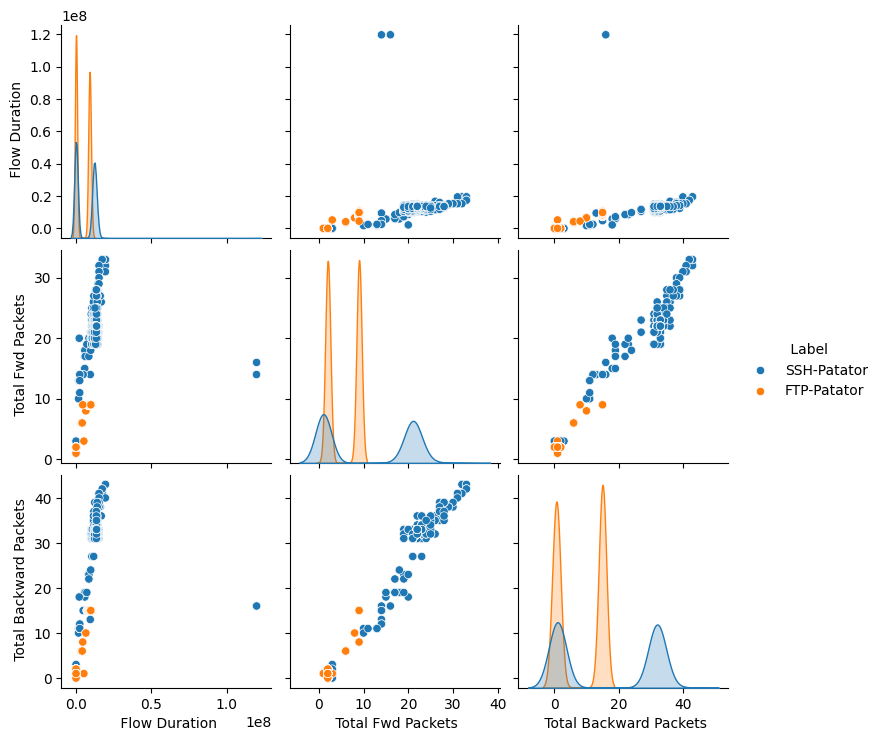

In [34]:
frames = [
    data[data[' Label']=="SSH-Patator"],
    data[data[' Label']=="FTP-Patator"]
]

df = pd.concat(frames)

pair_plot(df, ' Label', "Patator-Pairplot")

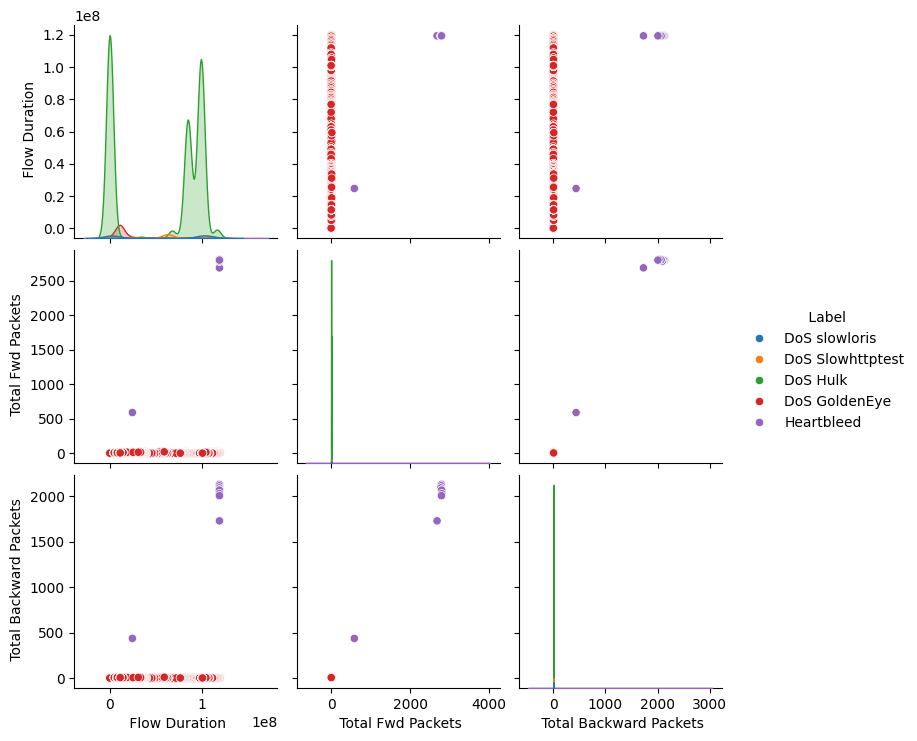

In [35]:
frames = [
    data[data[' Label']=='DoS slowloris'],
    data[data[' Label']=='DoS Slowhttptest'],
    data[data[' Label']=='DoS Hulk'],
    data[data[' Label']=='DoS GoldenEye'],
    data[data[' Label']=='Heartbleed']
]

df = pd.concat(frames)

pair_plot(df, ' Label', "DDoS-Attack-Pairplot")

In [23]:
def traffic_plot(label, count):
    # count[0] - benign record count
    # s - malicious record count
    s = 0
    for i in range(1,len(count)):
        s = s + count[i]
    labels = ["Benign", "Malicious"]
    counts = [count[0], s]
    fig, ax = plt.subplots(figsize=(10,10))
    ax.bar(labels, counts)
    rects = ax.patches
    labels = [f"Label: {labels[i]}, Records: {counts[i]}" for i in range(len(rects))]
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom"
        )
    ax.set_title('Network traffic type distribution', fontsize=16, fontweight="bold")
    ax.set_xlabel('Network traffic type')
    ax.set_ylabel('Distribution')
    ax.grid(which='Major', axis='both')
    ax.set_axisbelow(True)
    plt.savefig("images/plots/Traffic_type_distribution.png")

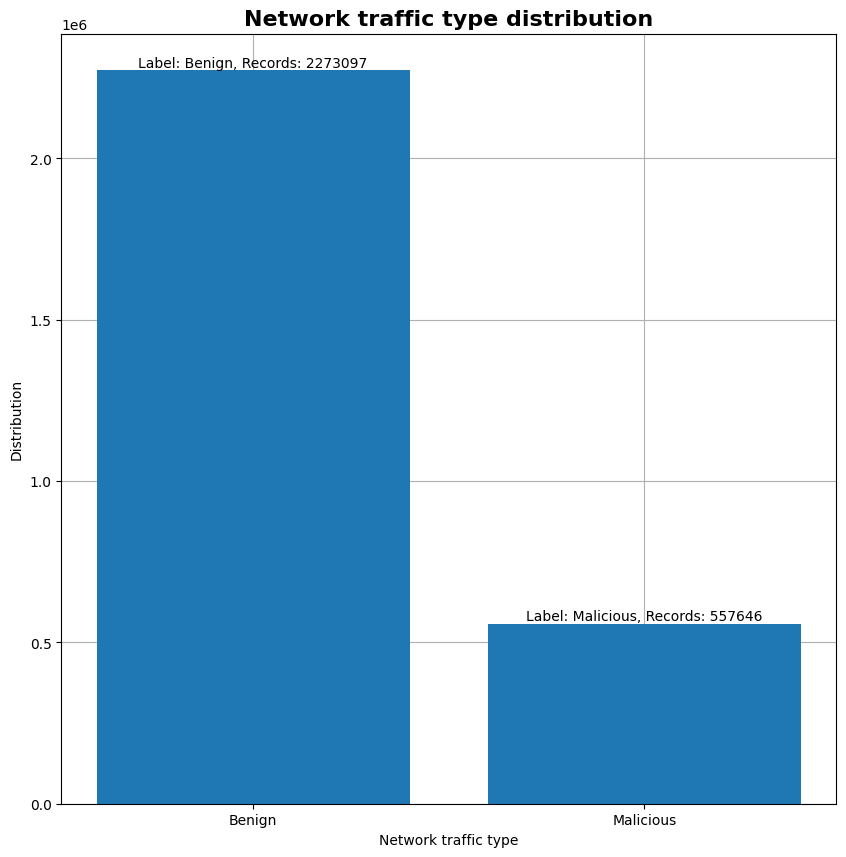

In [24]:
traffic_plot(labels, values)

In [22]:
labels

array(['BENIGN', 'FTP-Patator', 'SSH-Patator', 'DoS slowloris',
       'DoS Slowhttptest', 'DoS Hulk', 'DoS GoldenEye', 'Heartbleed',
       'Web Attack � Brute Force', 'Web Attack � XSS',
       'Web Attack � Sql Injection', 'Infiltration', 'DDoS', 'Bot',
       'PortScan'], dtype=object)

In [37]:
def attack_plot(labels, count):
    _dict, attacks = [{} for x in range(2)]
    label = [x for x in labels if x != 'BENIGN']
    count = count.iloc[1:len(count)]
    for x in range(len(label)):
        _dict[label[x]] = count.iloc[x]
    _dict["XSS"] = _dict["Web Attack � XSS"]
    _dict["SQL Injection"] = _dict["Web Attack � Sql Injection"]
    _dict["Brute Force"] = _dict["Web Attack � Brute Force"]
    del _dict["Web Attack � XSS"]
    del _dict["Web Attack � Sql Injection"]
    del _dict["Web Attack � Brute Force"]
    tmp = sorted(_dict.items(), key = lambda x:x[1], reverse=True)
    for x in tmp:
        attacks[x[0]] = x[1]
    fig, ax = plt.subplots(figsize=(10,10))
    ax.bar(attacks.keys(), attacks.values())
    rects = ax.patches
    labels = [f"{count[i]}" for i in range(len(rects))]
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom"
        )
    ax.set_title('Attack type distribution', fontsize=16, fontweight="bold")
    ax.set_xlabel('Traffic type')
    ax.tick_params(axis='x', labelrotation=90)
    ax.set_ylabel('Distribution')
    ax.grid(which='Major', axis='both')
    ax.set_axisbelow(True)
    plt.savefig("images/plots/Attack_type_distribution.png")

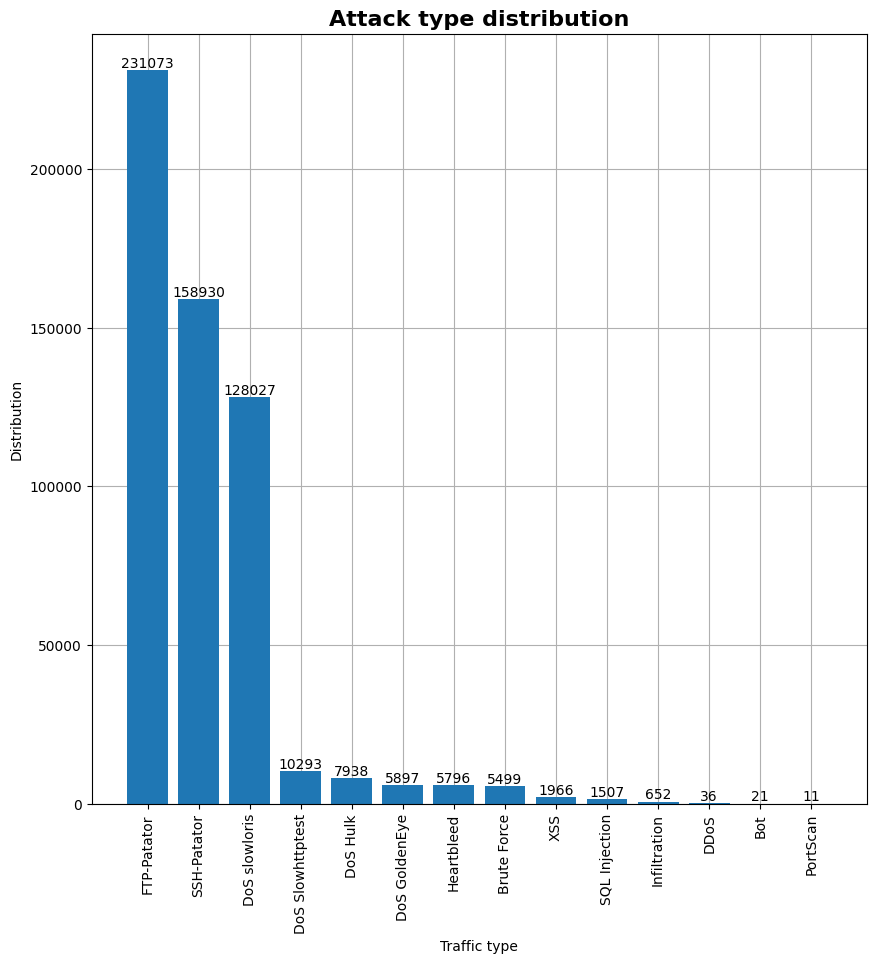

In [38]:
attack_plot(labels, values)

In [42]:
def patator_plot(label, count):
    _dict = {}
    for x in range(len(label)):
        _dict[label[x]] = count.iloc[x]
    fig, ax = plt.subplots(figsize=(10,10))
    ax.bar(_dict.keys(), _dict.values())
    rects = ax.patches
    labels = [f"Label: {label[i]}, Records: {count[i]}" for i in range(len(rects))]
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom"
        )
    ax.set_title('Patator attack type distribution', fontsize=16, fontweight="bold")
    ax.set_xlabel('Patator attack type')
    ax.set_ylabel('Distribution')
    ax.grid(which='Major', axis='both')
    ax.set_axisbelow(True)
    plt.savefig("images/plots/Patator_attack_distribution.png")

In [43]:
frames = [
    data[data[' Label']=="SSH-Patator"],
    data[data[' Label']=="FTP-Patator"]
]

df = pd.concat(frames)
label = df[' Label'].unique()
count = df[' Label'].value_counts()

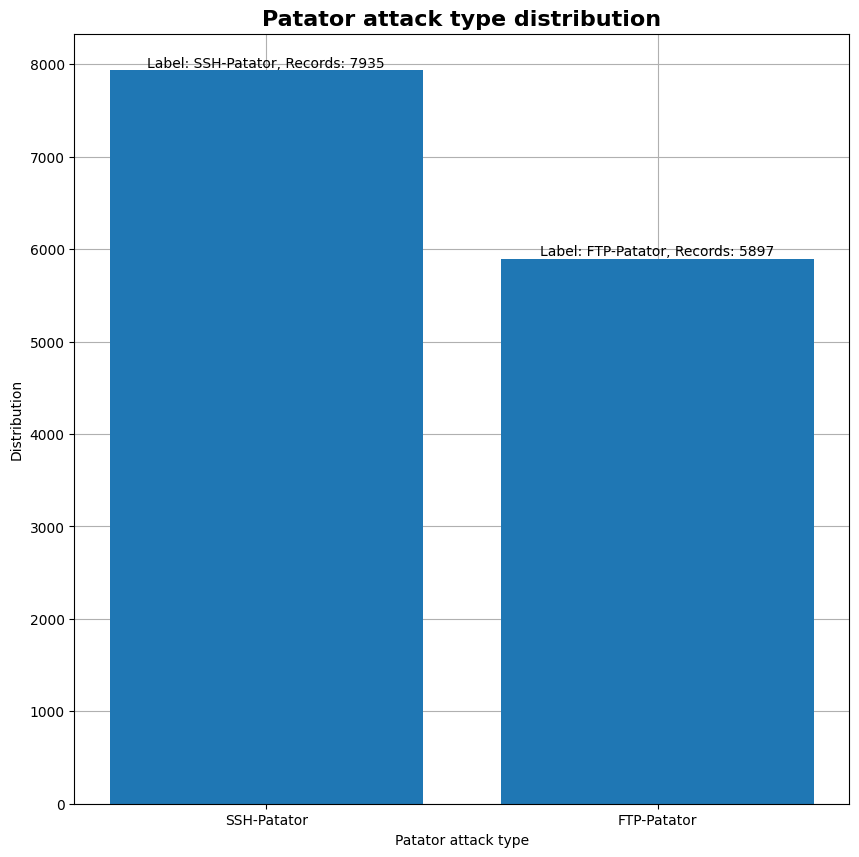

In [44]:
patator_plot(label, count)

In [48]:
def web_plot(label, count):
    _dict, attacks = [{} for x in range(2)]
    for x in range(len(label)):
        _dict[label[x]] = count.iloc[x]
    _dict["XSS"] = _dict["Web Attack � XSS"]
    _dict["SQL Injection"] = _dict["Web Attack � Sql Injection"]
    _dict["Brute Force"] = _dict["Web Attack � Brute Force"]
    del _dict["Web Attack � XSS"]
    del _dict["Web Attack � Sql Injection"]
    del _dict["Web Attack � Brute Force"]
    tmp = sorted(_dict.items(), key = lambda x:x[1], reverse=True)
    for x in tmp:
        attacks[x[0]] = x[1]
    fig, ax = plt.subplots(figsize=(10,10))
    ax.bar(attacks.keys(), attacks.values())
    rects = ax.patches
    labels = [f"Records: {count[i]}" for i in range(len(rects))]
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom"
        )
    ax.set_title('Web attack type distribution', fontsize=16, fontweight="bold")
    ax.set_xlabel('Web attack type')
    ax.set_ylabel('Distribution')
    ax.grid(which='Major', axis='both')
    ax.set_axisbelow(True)
    plt.savefig("images/plots/Web_attack_distribution.png")

In [49]:
frames = [
    data[data[' Label']=='Web Attack � Brute Force'],
    data[data[' Label']=='Web Attack � XSS'],
    data[data[' Label']=='Web Attack � Sql Injection']
]

df = pd.concat(frames)
label = df[' Label'].unique()
count = df[' Label'].value_counts()

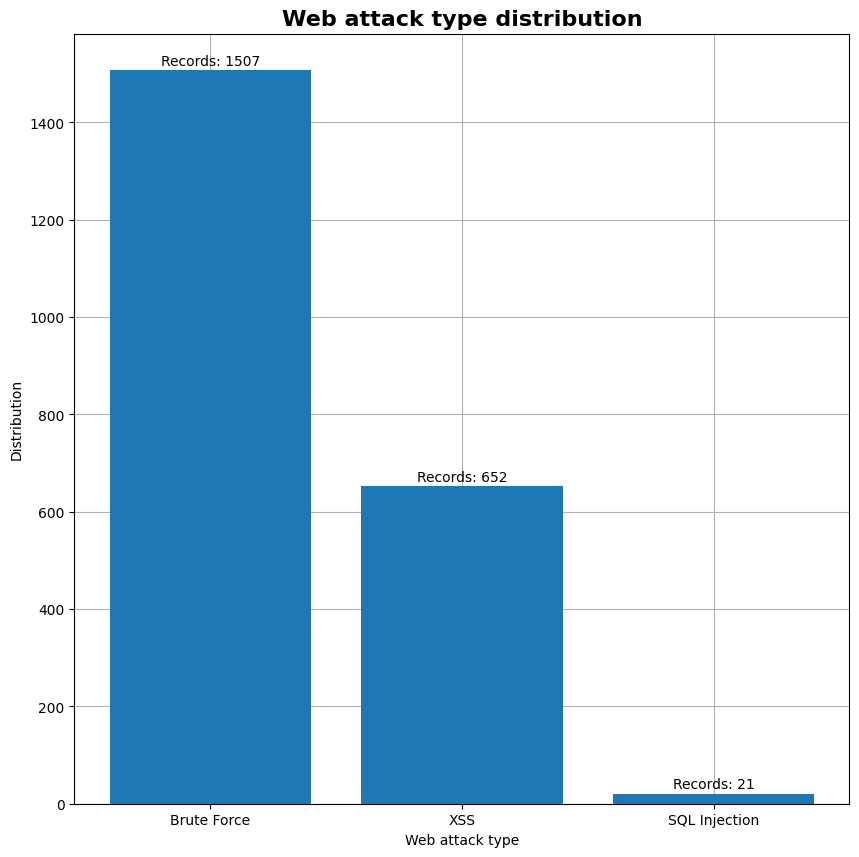

In [50]:
web_plot(label, count)

In [51]:
def dos_plot(label, count):
    _dict = {}
    for x in range(len(label)):
        _dict[label[x]] = count.iloc[x]
    fig, ax = plt.subplots(figsize=(10,10))
    ax.bar(_dict.keys(), _dict.values())
    rects = ax.patches
    labels = [f"Records: {count[i]}" for i in range(len(rects))]
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom"
        )
    ax.set_title('DDoS attack type distribution', fontsize=16, fontweight="bold")
    ax.set_xlabel('DDoS attack type')
    ax.set_ylabel('Distribution')
    ax.grid(which='Major', axis='both')
    ax.set_axisbelow(True)
    plt.savefig("images/plots/DDoS_attack_distribution.png")

In [52]:
frames = [
    data[data[' Label']=='DoS slowloris'],
    data[data[' Label']=='DoS Slowhttptest'],
    data[data[' Label']=='DoS Hulk'],
    data[data[' Label']=='DoS GoldenEye'],
    data[data[' Label']=='Heartbleed']
]

df = pd.concat(frames)
label = df[' Label'].unique()
count = df[' Label'].value_counts()

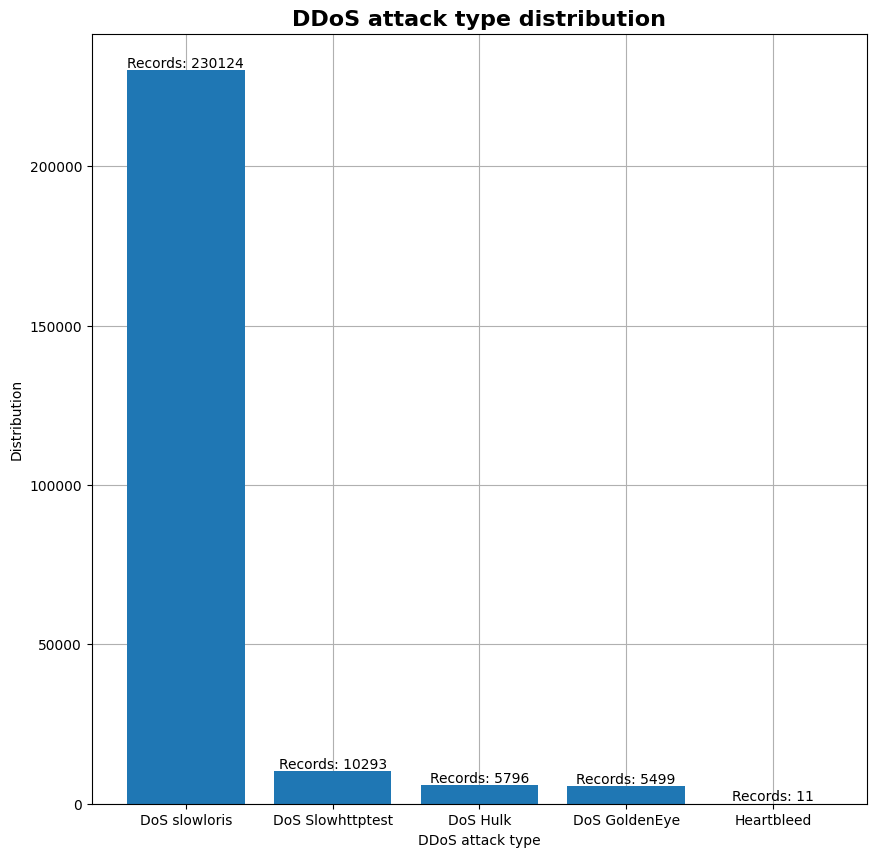

In [53]:
dos_plot(label, count)

# 4. Prepare data

In [19]:
X = data.drop([' Label', ' Class'], axis=1)
y = data[' Label']

In [20]:
X.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
0,49188,4,2,0,12,0,6,6,6.0,0.0,...,1,20,0.0,0.0,0,0,0.0,0.0,0,0
1,49188,1,2,0,12,0,6,6,6.0,0.0,...,1,20,0.0,0.0,0,0,0.0,0.0,0,0
2,49188,1,2,0,12,0,6,6,6.0,0.0,...,1,20,0.0,0.0,0,0,0.0,0.0,0,0
3,49188,1,2,0,12,0,6,6,6.0,0.0,...,1,20,0.0,0.0,0,0,0.0,0.0,0,0
4,49486,3,2,0,12,0,6,6,6.0,0.0,...,1,20,0.0,0.0,0,0,0.0,0.0,0,0


In [21]:
y.unique()

array(['BENIGN', 'FTP-Patator', 'SSH-Patator', 'DoS slowloris',
       'DoS Slowhttptest', 'DoS Hulk', 'DoS GoldenEye', 'Heartbleed',
       'Web Attack � Brute Force', 'Web Attack � XSS',
       'Web Attack � Sql Injection', 'Infiltration', 'DDoS', 'Bot',
       'PortScan'], dtype=object)

In [22]:
len(y.unique())

15

## 4.1 Data Normalization

In [23]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [24]:
X

array([[ 2.25050642, -0.43961241, -0.00982461, ..., -0.10951643,
        -0.35707153, -0.33918443],
       [ 2.25050642, -0.4396125 , -0.00982461, ..., -0.10951643,
        -0.35707153, -0.33918443],
       [ 2.25050642, -0.4396125 , -0.00982461, ..., -0.10951643,
        -0.35707153, -0.33918443],
       ...,
       [-0.41689841, -0.4348067 ,  0.08083571, ..., -0.10951643,
        -0.35707153, -0.33918443],
       [-0.41689841, -0.43536915,  0.05417091, ..., -0.10951643,
        -0.35707153, -0.33918443],
       [-0.41689841, -0.43406035,  0.04883795, ..., -0.10951643,
        -0.35707153, -0.33918443]])

## 4.2 Encode data

In [25]:
onehotencoder = OneHotEncoder()
y = y.values.reshape(-1, 1)
y = onehotencoder.fit_transform(y).toarray()
y = y[:, 0]

## 4.3 Principal component analysis

In [26]:
%%time
num_components = 10
pca = PCA(n_components=num_components)
X_pca = pca.fit_transform(X)
feature_selector = SelectKBest(score_func=f_classif, k='all')
X = feature_selector.fit_transform(X_pca, y)
X = X.reshape(X.shape[0], num_components, 1)

CPU times: user 4.05 s, sys: 1.19 s, total: 5.24 s
Wall time: 1.41 s


## 4.4 Save data

In [27]:
np.save('data/CIC_IDS_2017/prepared_train_data.npy', X)
np.save('data/CIC_IDS_2017/prepared_train_labels.npy', y)

## 4.5 Load data

In [28]:
X = np.load('data/CIC_IDS_2017/prepared_train_data.npy')
y = np.load('data/CIC_IDS_2017/prepared_train_labels.npy')

In [29]:
X

array([[[-2.20341917],
        [-0.04649812],
        [ 0.5388577 ],
        ...,
        [-0.18823211],
        [-0.24876228],
        [ 1.3845989 ]],

       [[-2.65783247],
        [-0.06213898],
        [ 0.80433841],
        ...,
        [ 0.16800908],
        [ 1.10542934],
        [-1.99055778]],

       [[-2.65783247],
        [-0.06213898],
        [ 0.80433841],
        ...,
        [ 0.16800908],
        [ 1.10542934],
        [-1.99055778]],

       ...,

       [[ 2.96579199],
        [ 0.59986647],
        [-5.2269146 ],
        ...,
        [ 2.82679641],
        [ 0.33933268],
        [-0.2927417 ]],

       [[ 2.00624895],
        [ 0.45068367],
        [-4.21600076],
        ...,
        [ 2.46204332],
        [-0.01862949],
        [-0.30590085]],

       [[ 1.99913966],
        [ 0.43758331],
        [-4.20599781],
        ...,
        [ 2.45912152],
        [-0.02805093],
        [-0.30215974]]])

In [30]:
y

array([1., 1., 1., ..., 1., 1., 1.])

# 5. Create a model

Testing these models:
1. K Nearest Neighbour
2. Random Forest
3. Gradient Boost:
    * XGBoost;
    * CatBoost;
    * LightGBM.
4. Support Vector Machine;
5. Neural Network.

In [27]:
def visualize_CM(matrix, name):
    """
    Visualize Correlation Matrix
    """
    heatmap = sns.heatmap(matrix,annot=True)
    fig = heatmap.get_figure()
    fig.savefig(f"images/confusion_matrices/{name}.png")

In [28]:
results_dict = {}

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2403694, 10), (2403694,), (424182, 10), (424182,))

## 5.1. K Nearest Neighbour

In [31]:
%%time

start = time.time()

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)
y_pred = knn_clf.predict(X_test)

end = time.time()

kNN_time = end - start

print(f"Time: {kNN_time}")

Time: 38.48692297935486
CPU times: user 38.3 s, sys: 73.8 ms, total: 38.4 s
Wall time: 38.5 s


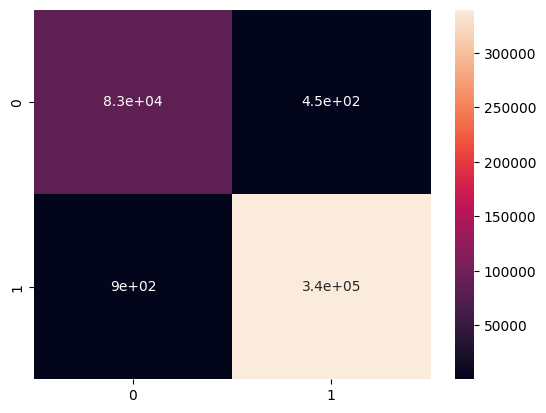

In [32]:
visualize_CM(confusion_matrix(y_test, y_pred), "kNN_CF")

In [33]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [34]:
results = [accuracy, precision, f1, recall, mae, mse, rmse, kNN_time]
results_dict["KNN"] = results

In [35]:
pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MAE", "MSE", "RMSE", "Time"])

,Accuracy,Precision,F1,Recall,MAE,MSE,RMSE,Time
KNN,0.996808,0.996818,0.996811,0.996808,0.003192,0.003192,0.056498,38.486923


## 5.2. Random Forest

In [36]:
rf_params = {
    'n_estimators': 10,
    'criterion': 'gini',
    'max_depth': None,
    'min_samples_split': 2,
    'min_samples_leaf': 1, 
    'min_weight_fraction_leaf': 0.0, 
    'max_features': 'sqrt', 
    'max_leaf_nodes': None, 
    'bootstrap': True, 
    'oob_score': False,
    'n_jobs': 8, 
    'random_state': None,
    'verbose': 1, 
    'warm_start': False, 
    'class_weight': None
}

In [37]:
%%time
start = time.time()

rf_clf = RandomForestClassifier(**rf_params)
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)

end = time.time()

RF_time = end - start

print(f"Time: {RF_time}")

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:   22.3s remaining:   14.8s


Time: 36.92940902709961
CPU times: user 3min 2s, sys: 1.03 s, total: 3min 3s
Wall time: 36.9 s


[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:   36.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.1s finished


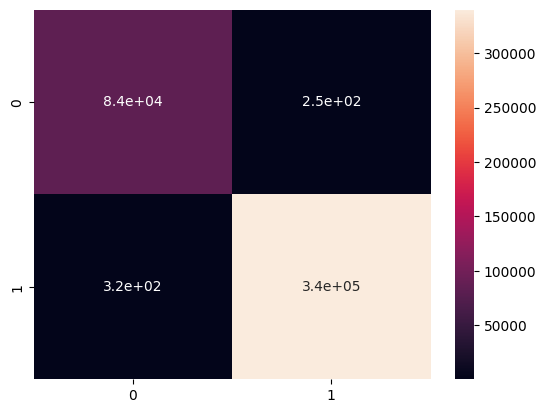

In [38]:
visualize_CM(confusion_matrix(y_test, y_pred), "RF_CF")

In [39]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [40]:
results = [accuracy, precision, f1, recall, mae, mse, rmse, RF_time]
results_dict["RF"] = results

In [41]:
pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MAE", "MSE", "RMSE", "Time"])

,Accuracy,Precision,F1,Recall,MAE,MSE,RMSE,Time
KNN,0.996808,0.996818,0.996811,0.996808,0.003192,0.003192,0.056498,38.486923
RF,0.998647,0.998647,0.998647,0.998647,0.001353,0.001353,0.036786,36.929409


## 5.3. XGBoost

In [42]:
%%time

start = time.time()

xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test)

end = time.time()

XGB_time = end-start

print(f"Time: {XGB_time}")

Time: 9.95353102684021
CPU times: user 1min 6s, sys: 218 ms, total: 1min 6s
Wall time: 9.95 s


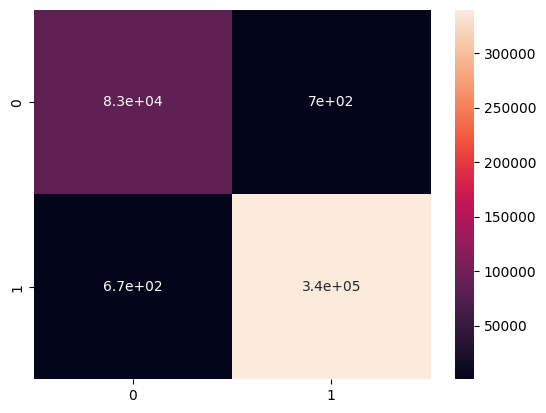

In [43]:
visualize_CM(confusion_matrix(y_test, y_pred), "XGBoost_CF")

In [44]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [45]:
results = [accuracy, precision, f1, recall, mae, mse, rmse, XGB_time]
results_dict["XGBoost"] = results

In [46]:
pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MAE", "MSE", "RMSE", "Time"])

,Accuracy,Precision,F1,Recall,MAE,MSE,RMSE,Time
KNN,0.996808,0.996818,0.996811,0.996808,0.003192,0.003192,0.056498,38.486923
RF,0.998647,0.998647,0.998647,0.998647,0.001353,0.001353,0.036786,36.929409
XGBoost,0.996758,0.996758,0.996758,0.996758,0.003242,0.003242,0.056934,9.953531


## 5.4. LightGBM

In [47]:
%%time

start = time.time()

lgbm_clf = lightgbm.LGBMClassifier()
lgbm_clf.fit(X_train, y_train)
y_pred = lgbm_clf.predict(X_test)

end = time.time()

LGBM_time = end - start

print(f"Time: {LGBM_time}")

[LightGBM] [Info] Number of positive: 1930893, number of negative: 472801
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026058 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 2403694, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.803302 -> initscore=1.407063
[LightGBM] [Info] Start training from score 1.407063
Time: 8.305063247680664
CPU times: user 31.7 s, sys: 42.3 ms, total: 31.7 s
Wall time: 8.31 s


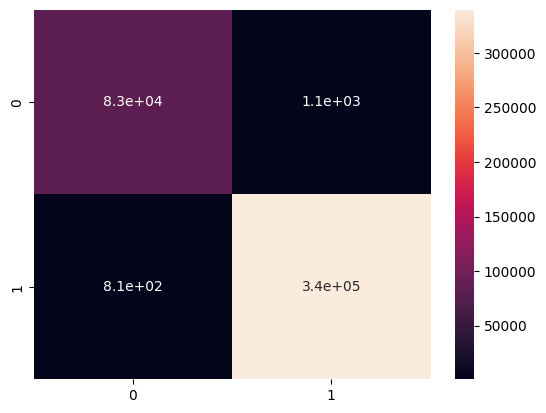

In [48]:
visualize_CM(confusion_matrix(y_test, y_pred), "LightGBM_CF")

In [49]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [50]:
results = [accuracy, precision, f1, recall, mae, mse, rmse, LGBM_time]
results_dict["LightGBM"] = results

In [51]:
pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MAE", "MSE", "RMSE", "Time"])

,Accuracy,Precision,F1,Recall,MAE,MSE,RMSE,Time
KNN,0.996808,0.996818,0.996811,0.996808,0.003192,0.003192,0.056498,38.486923
RF,0.998647,0.998647,0.998647,0.998647,0.001353,0.001353,0.036786,36.929409
XGBoost,0.996758,0.996758,0.996758,0.996758,0.003242,0.003242,0.056934,9.953531
LightGBM,0.995485,0.995481,0.995482,0.995485,0.004515,0.004515,0.067191,8.305063


## 5.5. Linear Support Vector Classifier

In [52]:
%%time

start = time.time()

svc_clf = LinearSVC(loss='hinge', C=10)
svc_clf.fit(X_train, y_train)
y_pred = svc_clf.predict(X_test)

end = time.time()

LSVC_time = end - start

print(f"Time: {LSVC_time}")

Time: 387.5614609718323
CPU times: user 6min 25s, sys: 296 ms, total: 6min 25s
Wall time: 6min 27s


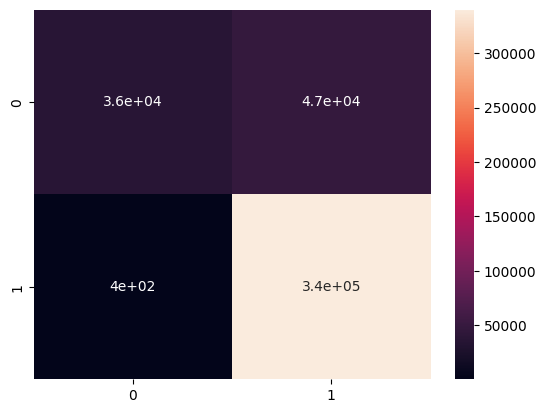

In [53]:
visualize_CM(confusion_matrix(y_test, y_pred), "LSVC_CF")

In [54]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [55]:
results = [accuracy, precision, f1, recall, mae, mse, rmse, LSVC_time]
results_dict["LSVC"] = results

In [56]:
pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MAE", "MSE", "RMSE", "Time"])

,Accuracy,Precision,F1,Recall,MAE,MSE,RMSE,Time
KNN,0.996808,0.996818,0.996811,0.996808,0.003192,0.003192,0.056498,38.486923
RF,0.998647,0.998647,0.998647,0.998647,0.001353,0.001353,0.036786,36.929409
XGBoost,0.996758,0.996758,0.996758,0.996758,0.003242,0.003242,0.056934,9.953531
LightGBM,0.995485,0.995481,0.995482,0.995485,0.004515,0.004515,0.067191,8.305063
LSVC,0.887346,0.899704,0.869018,0.887346,0.112654,0.112654,0.335640,387.561461


## 5.6. Feed Forward Neural Network

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.18)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((1971015, 20, 10, 1),
 (1971015, 10),
 (432662, 20, 10, 1),
 (432662, 10),
 (424179, 20, 10, 1),
 (424179, 10))

In [58]:
def create_model_FFNN(X_train, y_train):
    model = keras.Sequential()
    model.add(keras.layers.Dense(X_train.shape[1], activation='relu', input_shape=(X_train.shape[1],)))
    model.add(keras.layers.Dense(256, activation='relu'))
    model.add(keras.layers.Dense(256, activation='relu'))
    model.add(keras.layers.Dense(len(np.unique(y_train)), activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model
model = create_model_FFNN(X_train, y_train)

I0000 00:00:1738319995.567892  200273 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4866 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060, pci bus id: 0000:01:00.0, compute capability: 6.1


In [59]:
y_train

array([0., 1., 1., ..., 1., 1., 1.])

In [60]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │         2,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,232 (270.44 KB)

 Trainable params: 69,232 (270.44 KB)

 Non-trainable params: 0 (0.00 B)

In [87]:
%%time

start = time.time()

model.fit(X_train, y_train,
          batch_size=32,
          epochs=20,
          validation_data=(X_val, y_val))
gc.collect();

end = time.time()

FFNN_time = end - start

print(f"Time: {FFNN_time}")

2025-01-31 12:52:18.639364: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1583599200 exceeds 10% of free system memory.
2025-01-31 12:52:19.430524: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1583599200 exceeds 10% of free system memory.


Epoch 1/20
61860/61860 ━━━━━━━━━━━━━━━━━━━━ 423s 7ms/step - accuracy: 0.9813 - loss: 0.0613 - val_accuracy: 0.9910 - val_loss: 0.0263
Epoch 2/20
61860/61860 ━━━━━━━━━━━━━━━━━━━━ 487s 8ms/step - accuracy: 0.9919 - loss: 0.0265 - val_accuracy: 0.9953 - val_loss: 0.0160
Epoch 3/20
61860/61860 ━━━━━━━━━━━━━━━━━━━━ 460s 7ms/step - accuracy: 0.9944 - loss: 0.0188 - val_accuracy: 0.9962 - val_loss: 0.0127
Epoch 4/20
61860/61860 ━━━━━━━━━━━━━━━━━━━━ 432s 7ms/step - accuracy: 0.9953 - loss: 0.0158 - val_accuracy: 0.9963 - val_loss: 0.0122
Epoch 5/20
61860/61860 ━━━━━━━━━━━━━━━━━━━━ 412s 7ms/step - accuracy: 0.9958 - loss: 0.0141 - val_accuracy: 0.9968 - val_loss: 0.0107
Epoch 6/20
61860/61860 ━━━━━━━━━━━━━━━━━━━━ 445s 7ms/step - accuracy: 0.9961 - loss: 0.0133 - val_accuracy: 0.9970 - val_loss: 0.0101
Epoch 7/20
61860/61860 ━━━━━━━━━━━━━━━━━━━━ 421s 7ms/step - accuracy: 0.9964 - loss: 0.0124 - val_accuracy: 0.9972 - val_loss: 0.0095
Epoch 8/20
61860/61860 ━━━━━━━━━━━━━━━━━━━━ 440s 7ms/step - ac

In [91]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

13256/13256 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step


In [92]:
_, accuracy = model.evaluate(X_test, y_test)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

13256/13256 ━━━━━━━━━━━━━━━━━━━━ 43s 3ms/step - accuracy: 0.9979 - loss: 0.0065


ValueError: Classification metrics can't handle a mix of multilabel-indicator and binary targets

In [ ]:
results = [accuracy, precision, f1, recall, mae, mse, rmse, FFNN_time]
results_dict["FF-NN"] = results

In [ ]:
results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MAE", "MSE", "RMSE", "Time"])

In [ ]:
results_df

## 5.7. LSTM Neural Network

In [31]:
# Prepare sequential data
def create_sequences(features, labels, seq_length):
    sequences, seq_labels = [], []
    for i in range(len(features) - seq_length):
        sequences.append(features[i:i + seq_length])
        seq_labels.append(labels[i + seq_length - 1])  # Use the last label in the sequence
    return np.array(sequences), np.array(seq_labels)

In [32]:
# Create sequences
seq_length = 20
X, y = create_sequences(X, y, seq_length)
y = to_categorical(y, num_classes=num_components)  # Convert labels to one-hot encoding

In [33]:
# Split data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [34]:
def create_model_LSTM(input_shape, num_classes):
    model = keras.Sequential([
        keras.layers.LSTM(64, input_shape=input_shape, return_sequences=True),
        keras.layers.Dropout(0.3),
        keras.layers.LSTM(32),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(num_classes, activation='softmax')  # Use softmax for multi-class classification
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [35]:
# Build model
model = create_model_LSTM(input_shape=(seq_length, X.shape[2]), num_classes=num_components)

I0000 00:00:1738331644.786115  443412 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4466 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060, pci bus id: 0000:01:00.0, compute capability: 6.1


In [36]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 20, 64)         │        19,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,378 (134.29 KB)

 Trainable params: 34,378 (134.29 KB)

 Non-trainable params: 0 (0.00 B)

In [37]:
%%time

start = time.time()

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=8192,
    validation_data=(X_val, y_val)
)

end = time.time()

LSTM_time = end - start

print(f"Time: {LSTM_time}")

2025-01-31 15:54:08.246387: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1583599200 exceeds 10% of free system memory.
2025-01-31 15:54:09.662530: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1583599200 exceeds 10% of free system memory.


Epoch 1/100


I0000 00:00:1738331653.058553  445035 cuda_dnn.cc:529] Loaded cuDNN version 90600


242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.8012 - loss: 0.8351 

2025-01-31 15:54:39.302368: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 339342400 exceeds 10% of free system memory.
2025-01-31 15:54:39.419933: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 339342400 exceeds 10% of free system memory.


242/242 ━━━━━━━━━━━━━━━━━━━━ 31s 115ms/step - accuracy: 0.8016 - loss: 0.8333 - val_accuracy: 0.9702 - val_loss: 0.1129
Epoch 2/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 27s 112ms/step - accuracy: 0.9714 - loss: 0.1116 - val_accuracy: 0.9765 - val_loss: 0.0837
Epoch 3/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 27s 113ms/step - accuracy: 0.9761 - loss: 0.0862 - val_accuracy: 0.9807 - val_loss: 0.0626
Epoch 4/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 27s 112ms/step - accuracy: 0.9802 - loss: 0.0688 - val_accuracy: 0.9838 - val_loss: 0.0534
Epoch 5/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 27s 113ms/step - accuracy: 0.9824 - loss: 0.0601 - val_accuracy: 0.9840 - val_loss: 0.0510
Epoch 6/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 27s 113ms/step - accuracy: 0.9835 - loss: 0.0552 - val_accuracy: 0.9860 - val_loss: 0.0447
Epoch 7/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 27s 113ms/step - accuracy: 0.9847 - loss: 0.0508 - val_accuracy: 0.9867 - val_loss: 0.0423
Epoch 8/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 28s 113ms/step - accuracy: 0.9854 - loss: 0.047

In [38]:
# Evaluate model
y_pred = model.predict(X_test)

2025-01-31 16:39:13.586543: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 339343200 exceeds 10% of free system memory.


13256/13256 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step


In [39]:
_, accuracy = model.evaluate(X_test, y_test)

13256/13256 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - accuracy: 0.9967 - loss: 0.0105


In [40]:
y_test = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)

In [41]:
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [42]:
results = [accuracy, precision, f1, recall, mae, mse, rmse, LSTM_time]
results_dict["LSTM"] = results

In [44]:
results_dict["LSTM"]

[0.9966193437576294,
 0.9966160178936931,
 0.9966156295625793,
 0.9966193517359416,
 0.0033806482640583338,
 0.0033806482640583338,
 0.05814334238808717,
 2707.433171272278]

In [108]:
results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MAE", "MSE", "RMSE", "Time"])

In [109]:
results_df

,Accuracy,Precision,F1,Recall,MAE,MSE,RMSE,Time
KNN,0.996808,0.996818,0.996811,0.996808,0.003192,0.003192,0.056498,38.486923
RF,0.998647,0.998647,0.998647,0.998647,0.001353,0.001353,0.036786,36.929409
XGBoost,0.996758,0.996758,0.996758,0.996758,0.003242,0.003242,0.056934,9.953531
LightGBM,0.995485,0.995481,0.995482,0.995485,0.004515,0.004515,0.067191,8.305063
LSVC,0.887346,0.899704,0.869018,0.887346,0.112654,0.112654,0.335640,387.561461
FF-NN,0.989662,0.989634,0.989619,0.989662,0.010338,0.010338,0.101674,8463.438555
LSTM,0.998293,0.998292,0.998293,0.998293,0.001707,0.001707,0.041314,32.433929


# 6. Plotting data

In [45]:
results = {
    "kNN": [0.996808, 0.996818, 0.996811, 0.996808, 0.003192, 0.003192, 0.056498, 38.486923],
    "RF": [0.998647, 0.998647, 0.998647, 0.998647, 0.001353, 0.001353, 0.036786, 36.929409],
    "XGBoost": [0.996758, 0.996758, 0.996758, 0.996758, 0.003242, 0.003242, 0.056934, 9.953531],
    "LightGBM": [0.995485, 0.995481, 0.995482, 0.995485, 0.004515, 0.004515, 0.067191, 8.305063],
    "LSVC": [0.887346, 0.899704, 0.869018, 0.887346, 0.112654, 0.112654, 0.335640, 387.561461],
    "FF-NN": [0.989662, 0.989634, 0.989619, 0.989662, 0.010338, 0.010338, 0.101674, 8463.438555],
    "LSTM": [0.9966193437576294, 0.9966160178936931, 0.9966156295625793, 0.9966193517359416, 0.0033806482640583338, 0.0033806482640583338, 0.05814334238808717, 2707.433171272278]
}
results_df = pd.DataFrame.from_dict(results, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MAE", "MSE", "RMSE", "Time"])

In [46]:
def result_plot(_dict, name):
    attacks = {}
    higher = ["F1", "Accuracy", "Precision", "Recall"]
    fig, ax = plt.subplots(figsize=(10,10))
    if name in higher:
        tmp = sorted(_dict.items(), key = lambda x:x[1])
    else:
        tmp = sorted(_dict.items(), key = lambda x:x[1], reverse=True)
    for x in tmp:
        attacks[x[0]] = x[1]
    ax.bar(attacks.keys(), attacks.values())
    rects = ax.patches
    results = [i for i in attacks.values()]
    labels = [f"{results[i]:.6f}" for i in range(len(rects))]
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height, label, ha="center", va="bottom"
        )
    if name in higher:
        ax.set_title(f'{name} (higher is better)', fontsize=16, fontweight="bold")
    else:
        ax.set_title(f'{name} (lower is better)', fontsize=16, fontweight="bold")
    ax.set_xlabel(f'{name}')
    ax.set_ylabel('Score')
    ax.grid(which='Major', axis='both')
    ax.set_axisbelow(True)
    plt.savefig(f"images/results/{name}.png")

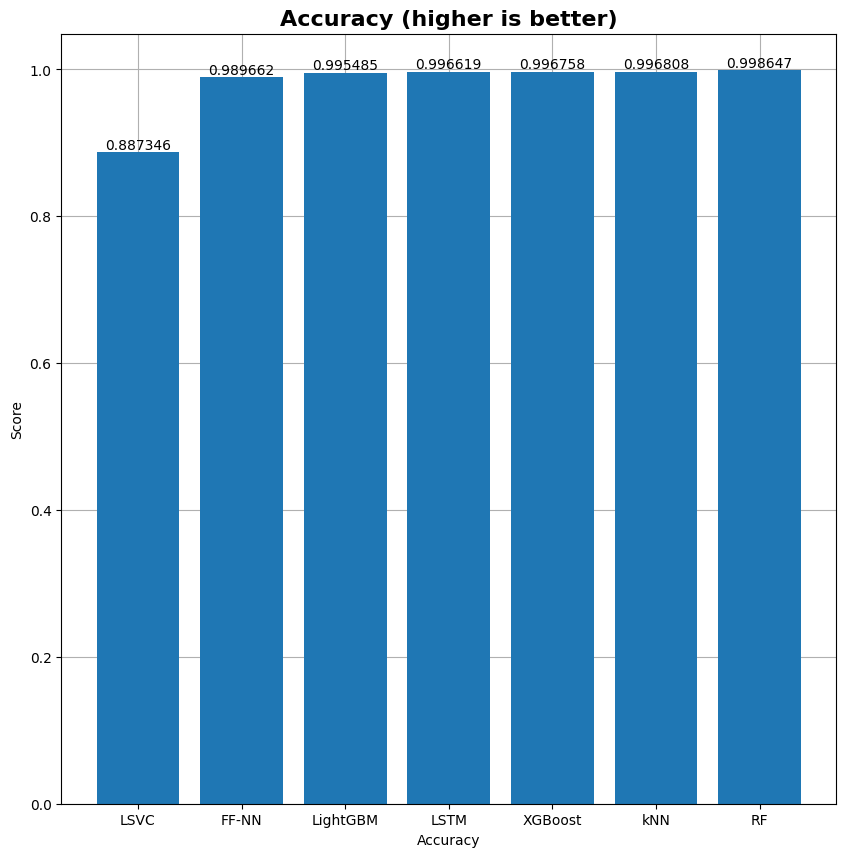

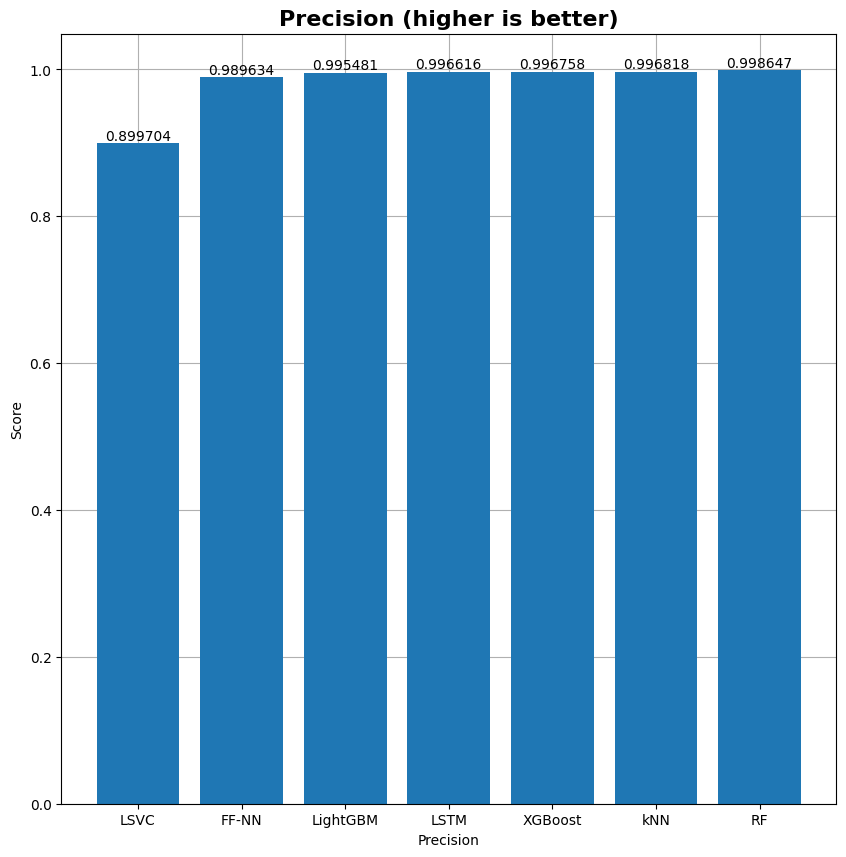

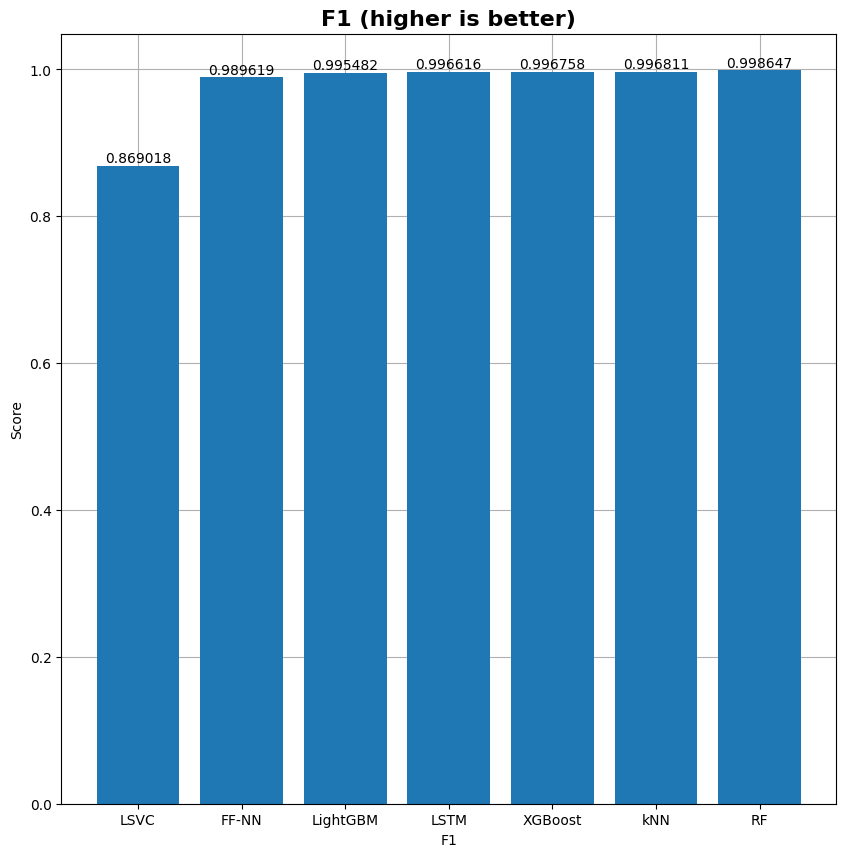

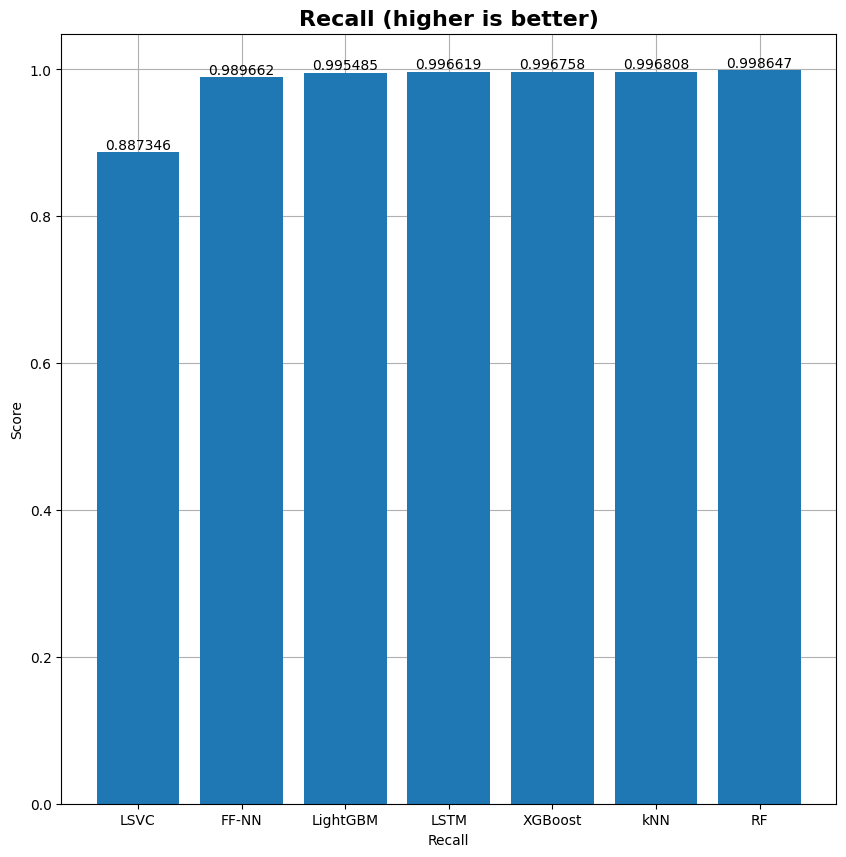

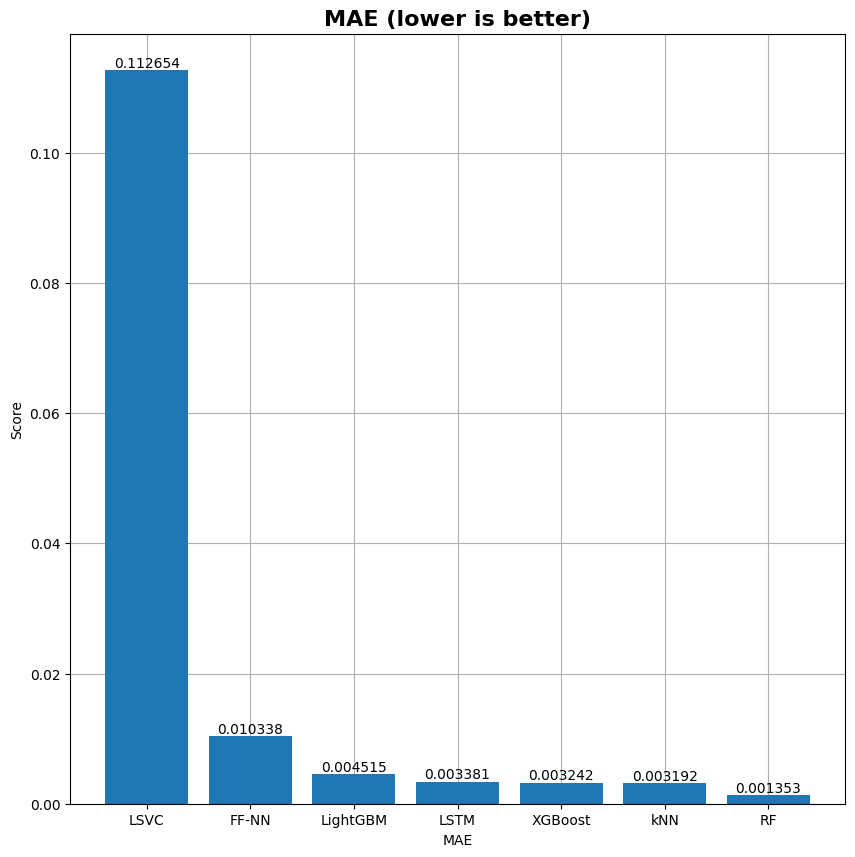

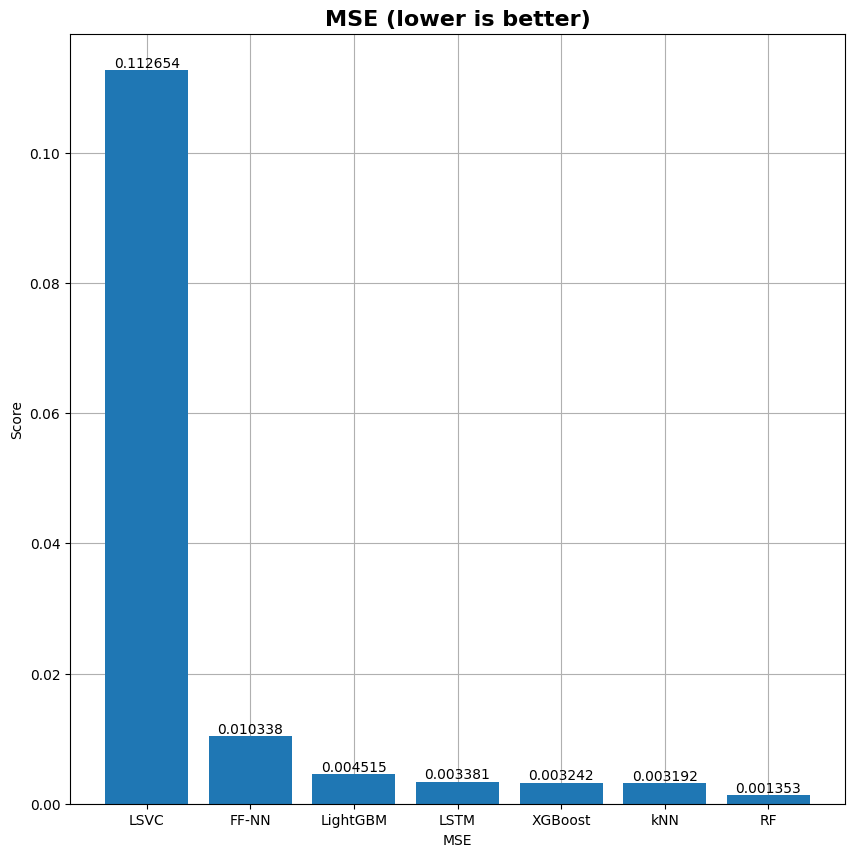

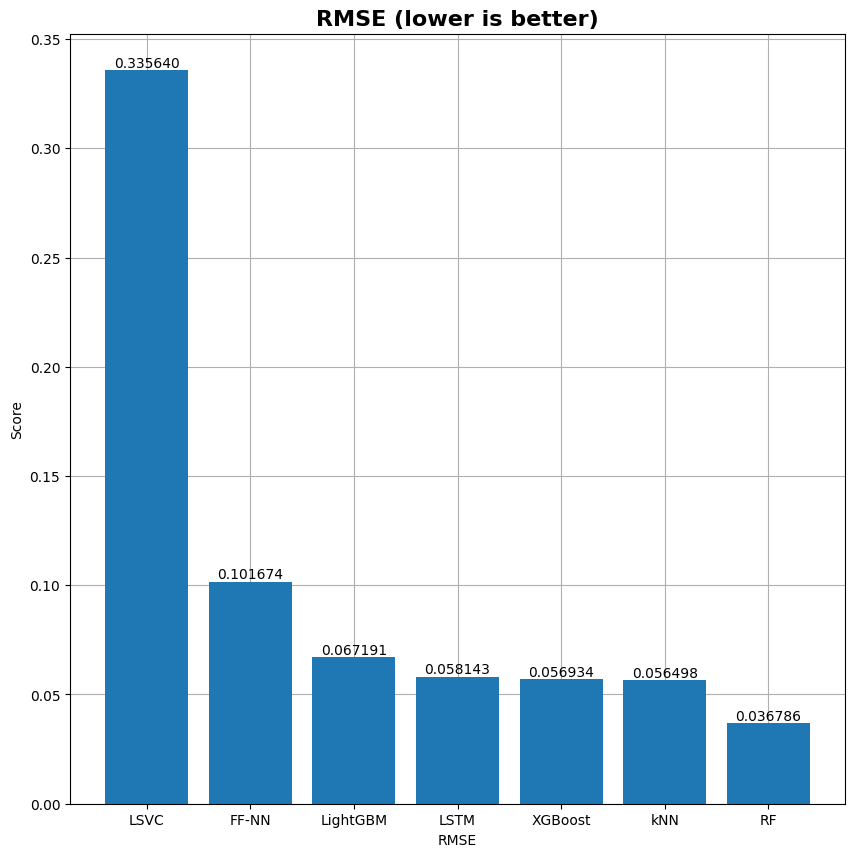

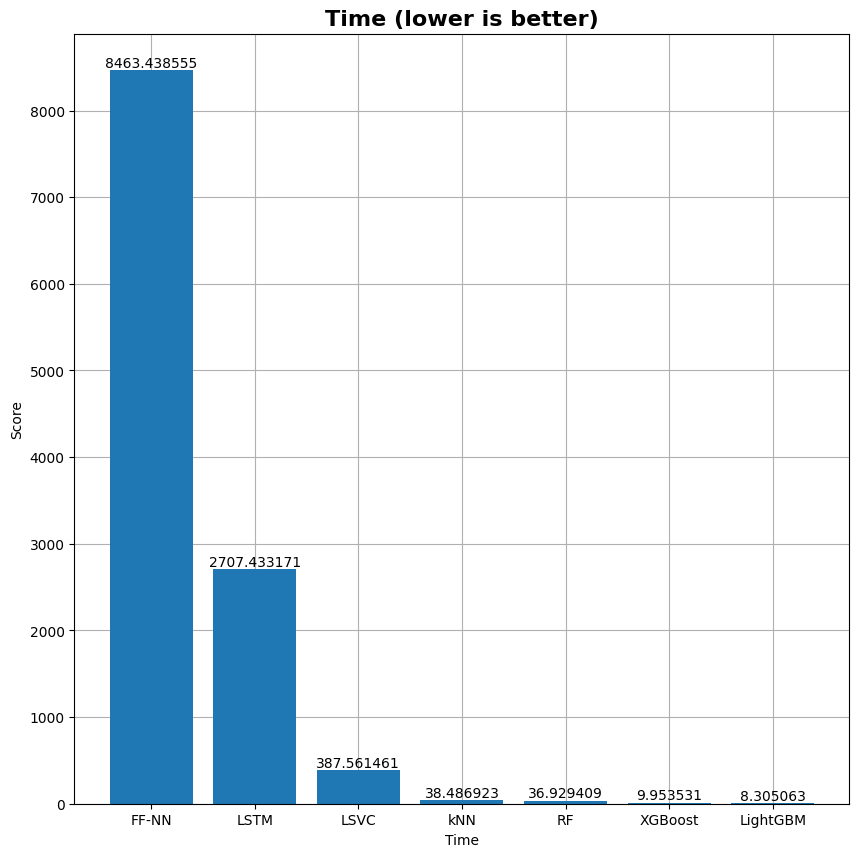

In [47]:
for x in results_df:
    _dict = {}
    name = results_df[x].name
    for keys, values in zip(range(len(results_df[x].keys())), results_df[x]):
        _dict[results_df[x].keys()[keys]] = values
    result_plot(_dict, name)